# Exploratory data analysis of barcode sequencing test run

In [1]:
using wgregseq, CSV, DataFrames, Glob, BioSequences, CairoMakie, Statistics, StatsBase

# Set plotting style
wgregseq.plotting_style.default_makie!()

Import mapped sequences.

In [2]:
df_mapped = CSV.read("../../../data/barcodes/20220514_mapping/mapped_barcodes.csv", DataFrame)
first(df_mapped, 5)

,promoter
,String
1,GAAGACGACAAACTCATTCATCTCATGGCTGCCGTAGGAGACCGTGAGTGGTAATACGATAACGCACTCACCATAGATGTGTACTGTAAAGATTTCCCTGGCTTTTATGACTGGATGGAATACCCCGGTCACCCAGTTAAGTTTGTTTTTCACATACATG
2,GAGGACGACATACGCATTCATCTCTTGGCTGCCGTACGAGACTGTGAGTGGTCAGACGATAATGCCCTCACCATAAATGTGCAGTTTCATGATTTCCCTGTATTAGATGACTGGATGGATTGCCCTTATCACCCGATTAACTGCGTTTTTCACATACTTG
3,GATTACGACAAACTCATTCATCTCATGGCTGCCGTACGAGACTGTGAGTCGTCATGCGATAACGCACTCACCATAGATTTGTAGTCTAATGATTTCCCTGGATTTTATGACAGGATGGCTTTCCCTGCTCCCCCGACTAAGTTTGCTTTTCACATACTTG
4,GATAACGACTAACTCATTCATCTCATGGCTGCCGTACGAGACTTTTCCTGGGCAGAAGATAACCCACTCACCATAAATGAGCAGTTTAATGATTTCCCTGGATGTTGTGACTGTATGGATTACCCTGATCACCCGGTTAAATTTGTTATTCCCATACTTG
5,GATGACGATAAATTCATTCATCTGATGGCTGCCGCACGAGACTCTGAGTGGTCAGACGATAATGCACTCACCATAAATGTACAGCTAAATGTTTTCCCTCGATTTTATCACTGGATGGATTCCCCTGATCACCGGGTTCAGTTTGTTTTTCACATCCTTG


Remove any non-unique barcodes.

In [3]:
# Find non-unique entries
index = df_mapped[!, ["barcode"]] |> nonunique

# Remove non-unique entries
df_mapped_un = df_mapped[ .~ index, :]

first(df_mapped_un, 5)

,promoter
,String
1,GAAGACGACAAACTCATTCATCTCATGGCTGCCGTAGGAGACCGTGAGTGGTAATACGATAACGCACTCACCATAGATGTGTACTGTAAAGATTTCCCTGGCTTTTATGACTGGATGGAATACCCCGGTCACCCAGTTAAGTTTGTTTTTCACATACATG
2,GAGGACGACATACGCATTCATCTCTTGGCTGCCGTACGAGACTGTGAGTGGTCAGACGATAATGCCCTCACCATAAATGTGCAGTTTCATGATTTCCCTGTATTAGATGACTGGATGGATTGCCCTTATCACCCGATTAACTGCGTTTTTCACATACTTG
3,GATTACGACAAACTCATTCATCTCATGGCTGCCGTACGAGACTGTGAGTCGTCATGCGATAACGCACTCACCATAGATTTGTAGTCTAATGATTTCCCTGGATTTTATGACAGGATGGCTTTCCCTGCTCCCCCGACTAAGTTTGCTTTTCACATACTTG
4,GATAACGACTAACTCATTCATCTCATGGCTGCCGTACGAGACTTTTCCTGGGCAGAAGATAACCCACTCACCATAAATGAGCAGTTTAATGATTTCCCTGGATGTTGTGACTGTATGGATTACCCTGATCACCCGGTTAAATTTGTTATTCCCATACTTG
5,GATGACGATAAATTCATTCATCTGATGGCTGCCGCACGAGACTCTGAGTGGTCAGACGATAATGCACTCACCATAAATGTACAGCTAAATGTTTTCCCTCGATTTTATCACTGGATGGATTCCCCTGATCACCGGGTTCAGTTTGTTTTTCACATCCTTG


Write a function that joins two columns in a dataframe.

In [ ]:
"""
    function joincols(df, column1::Union{Symbol, String}, column2::Union{Symbol, String})

Join two columns of dataframe. If one column has an entry as `missing`, entry from other column
is taken. If both columns have an entry, they need to be identical.
"""
function joincols(df, column1::Union{Symbol, String}, column2::Union{Symbol, String})
    new_col = []
    # Iterate through columns
    for (x, y) in zip(df[:, column1], df[:, column2])
        # Check if entries are missing
        miss_arr = [~ismissing(x), ~ismissing(y)]
        if all(miss_arr)
            if x != y
                throw(ErrorException("Columns have non-unique entries"))
            else
                push!(new_col, x)
            end
        elseif any(miss_arr)
            push!(new_col, [x, y][miss_arr])
        elseif all(.~ miss_arr)
            push!(new_col, missing)
        end
    end
    return new_col
end

Iterate through growth conditions and import reads for DNA and RNA. Then identify the promoters using the barcode and combine DNA and RNA counts.

In [105]:
df_all = DataFrame()
for gc in ["Etoh", "Gluc", "LB", "XyAr"]
    df_cdna = CSV.read(
        "../../../data/processed_barcodes/20221025_barcode_test/$(gc)_cDNA_collapsed.txt", 
        DataFrame, 
        ignorerepeated=true, 
        delim=" ",
        header=["counts", "barcode"]
        )


    df_gdna = CSV.read(
        "../../../data/processed_barcodes/20221025_barcode_test/$(gc)_gDNA_collapsed.txt", 
        DataFrame, 
        ignorerepeated=true, 
        delim=" ",
        header=["counts", "barcode"]
        )
        

    dfg = leftjoin(df_gdna, df_mapped_un, on="barcode", makeunique=true)
    dfc = leftjoin(df_cdna, df_mapped_un, on="barcode", makeunique=true)
    _df = outerjoin(dfg, dfc, on=["barcode"], renamecols="_DNA" =>"_RNA")
  
    _df.counts_RNA = coalesce.(_df.counts_RNA, 0)
    _df.counts_DNA = coalesce.(_df.counts_DNA, 0)

    insertcols!(_df, 1, :growth_condition => gc)
    append!(df_all, _df)
end

insertcols!(df_all, 1, :name => joincols(df_all, :name_RNA, :name_DNA))
insertcols!(df_all, 1, :promoter => joincols(df_all, :promoter_RNA, :promoter_DNA))

df_all = df_all[:, [:growth_condition, :name, :counts_DNA, :counts_RNA, :promoter, :barcode]]
first(df_all, 5)

,growth_condition,name,counts_DNA,counts_RNA,promoter
,String,Any,Int64,Int64,Any
1,Etoh,TSS_1414_storz_regulondb,23,50,GATGACCACAGACTCAGTCATCTCATGGCTGCCGTACGAGCCTGTGCGTGGTCAGACGATAACGAACTCACCATAAATGTGCAGTTTAAAGAATTCCCTGGATACTATGACTTGCTGGATTTCCCTGATCACCCGGCTACGTTTGTTTTTCACATAATTG
2,Etoh,TSS_1414_storz_regulondb,2,58,GATGACGACAAGCTCATTCATGTCATGGCGGCCGCACGAGACTGTGAGTGTTCAGACGATACCGCACTCACGATAAATGTGCGGTTTAATGACTTCCCAGGATTATAAGACTGGATGGATTCCCCTGATTACCCGGTTAAGTTTGTTTTTCAAATACTTC
3,Etoh,TSS_1414_storz_regulondb,12,65,GCCGACGACAAACTCATTCATCTCAATGCTGCCGTACGTGACTGTTAGTAGTCACACGATAACGCACTCGTCATAAATGTGCAGTTTAATGATTTCCCTGGATTTTATGACTGAATGGATTACCCTGATCACCCGGGTAAGCTTGTTTTGCAGTTACTTG
4,Etoh,TSS_1414_storz_regulondb,2,51,GAGGATGACAAACTCATTTATCTCATGGACGCCGTACGCGAGTGTGAGTGGCCAGTCTATAACGCACTCGCCATAAATGTGCAAGTTAATGATTACCCTGGATTTTATGACTGGTTGGATTACCCTGATCACCCGGTTAAGTTTGTTTTTCACGTACTTG
5,Etoh,TSS_1414_storz_regulondb,2,157,GATGACGAGACACTCATTCATCTTATGGCTGCCGTAACCGACTGTGAGTTGTCAGACGATAACGCACTCTCCATAAATGTGCAGTTTCAGGATTTCCCTGGAGTGTATGACTGGATGGATTACCCTGATCACCAAGTTAAGTTTGTTTTTCTCATACCTG


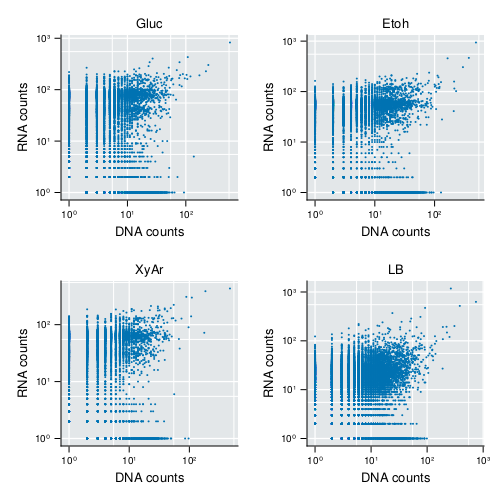

In [101]:
fig = Figure(resolution=(500, 500))
for (i, gc) in enumerate(["Etoh", "Gluc", "LB", "XyAr"])
    ax = Axis(
        fig[(i-1)÷2 + 1, i%2],
        xlabel="DNA counts",
        ylabel="RNA counts",
        title=gc,
        xscale=log10,
        yscale=log10
        )
    scatter!(
        ax, 
        df_all[df_all.growth_condition .== gc, :counts_DNA] .+ 1, 
        df_all[df_all.growth_condition .== gc, :counts_RNA] .+ 1,
        markersize=2
        )

end
fig

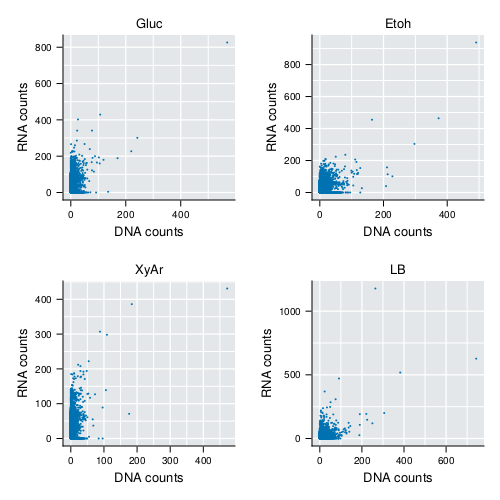

In [102]:
fig = Figure(resolution=(500, 500))
for (i, gc) in enumerate(["Etoh", "Gluc", "LB", "XyAr"])
    ax = Axis(
        fig[(i-1)÷2 + 1, i%2],
        xlabel="DNA counts",
        ylabel="RNA counts",
        title=gc,
        )
    scatter!(
        ax, 
        df_all[df_all.growth_condition .== gc, :counts_DNA], 
        df_all[df_all.growth_condition .== gc, :counts_RNA],
        markersize=2
        )

end
fig

In [64]:
combine(groupby(df_all, "growth_condition"), :counts_DNA => sum => :total_DNA_Counts) |> display
combine(groupby(df_all, "growth_condition"), :counts_RNA => sum => :total_RNA_Counts) |> display

,growth_condition,total_DNA_Counts
,String,Int64
1,Etoh,595853
2,Gluc,411264
3,LB,533304
4,XyAr,312938


,growth_condition,total_RNA_Counts
,String,Int64
1,Etoh,488722
2,Gluc,571266
3,LB,412979
4,XyAr,391747


In [125]:
df_DNA_std = combine(groupby(df_all, "barcode"), :counts_DNA => std)
df_RNA_std = combine(groupby(df_all, "barcode"), :counts_RNA => std)


df_DNA_std = df_DNA_std[.~ isnan.(df_DNA_std.counts_DNA_std), :]
df_RNA_std = df_RNA_std[.~ isnan.(df_RNA_std.counts_RNA_std), :]

println("Mean standard deviation of DNA counts per barcode across growth conditions: $(mean(df_DNA_std.counts_DNA_std))")
println("Mean standard deviation of RNA counts per barcode across growth conditions: $(mean(df_RNA_std.counts_RNA_std))")

Mean standard deviation of DNA counts per barcode across growth conditions: 1.0165071846383562
Mean standard deviation of RNA counts per barcode across growth conditions: 3.781128621963257


In [129]:
combine(groupby(df_all, "growth_condition"), :counts_DNA => std) |> display
combine(groupby(df_all, "growth_condition"), :counts_RNA => std) |> display

,growth_condition,counts_DNA_std
,String,Float64
1,Etoh,4.03182
2,Gluc,3.16186
3,LB,4.43327
4,XyAr,2.63507


,growth_condition,counts_RNA_std
,String,Float64
1,Etoh,11.2175
2,Gluc,14.9834
3,LB,8.06398
4,XyAr,11.998


In [139]:
df_bc_DNA = combine(groupby(df_all, "barcode"), :counts_DNA => length => :rows) 
println(mean(df_bc_DNA.rows))
println(median(df_bc_DNA.rows))

2.0286211122014715
2.0


In [115]:
coalesce(NaN, 1)

NaN